In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from collections import Counter

Level 1 SDG methods on Law School Admissions Bar Passage Dataset

link: https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage/data

The goal of SDG is mitigating bias in therms of gender, race and background

In [2]:
#load the dataset
dataset_path = 'C:/Users/20181588/Desktop/AA SDG/synthetic-data-generation/Law School Admissions Bar Passage/Dataset/bar_pass_prediction.csv'
original_data = pd.read_csv(dataset_path)
# Make a copy of the dataset
data_full = original_data.copy()

Drop useless features

Features that are useful are:

ugpa - This one stands for undergraduate gpa. Every other feature with gpa in it either perfectly correlates or perfectly negatively correlates with ugpa and this is the one I decided to keep.

decile1, decile1b, decile3 - These features represent the law school rankings by decile of each candidate in years 1 and 3 (and I’m assuming year one second semester, but I can’t be sure about that).

lsat - This feature is obviously the LSAT score of each candidate, but oddly it’s not formatted in the 120 to 180 score range of the actual LSAT. That said it has a strong correlation to whether someone passed the bar and, well, the feature is called lsat!

grad - This seems to be whether the student who took the bar exam graduated from law school. It’s a binary variable and there are very few 0s, so that makes the most sense. (Special kudos to the 65 students surveyed who didn’t graduate law school, but still managed to pass the bar!)

fulltime - Was the student a full-time student.

fam_inc - This feature is family income by quintile.

tier - What tier law school did the student attend by quintile.

race1 - Categorizes students by race. Of all the race variables this was the most complete, so it’s the one I kept. All the information contained in the other race variables are contained in race1.

sex - student gender.

pass_bar - This is the target variable. Did the student pass the bar.

In [3]:
data_full.columns

Index(['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster',
       'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr',
       'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime',
       'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'gpa'],
      dtype='object')

In [4]:
# List of columns to keep
columns_to_keep = [
    'pass_bar',  'ugpa', 'decile1', 'decile1b', 
    'decile3', 'lsat', 'grad', 'fulltime', 'fam_inc', 
    'tier', 'race1', 'sex'
]

# Creating a new DataFrame with only the selected features
data = data_full[columns_to_keep].copy()

In [5]:
data.columns

Index(['pass_bar', 'ugpa', 'decile1', 'decile1b', 'decile3', 'lsat', 'grad',
       'fulltime', 'fam_inc', 'tier', 'race1', 'sex'],
      dtype='object')

Change all columns content into numerical 

In [6]:
# Convert 'grad' to binary where 'Y' is 1 and anything else is 0
data['grad'] = data['grad'].apply(lambda x: 1 if x == 'Y' else 0)

# Verify the transformation
print(data['grad'].head())


0    1
1    1
2    1
3    1
4    1
Name: grad, dtype: int64


In [7]:
# Create a mapping from race category to a numeric value
race_mapping = {'white': 1, 'hisp': 2, 'asian': 3, 'black': 4, 'other': 5}

# Apply the mapping to the 'race1' column
data['race1'] = data['race1'].map(race_mapping)


Basic Dataset Exploration

In [8]:
data.head()

,pass_bar,ugpa,decile1,decile1b,decile3,lsat,grad,fulltime,fam_inc,tier,race1,sex
0,1,3.5,10.0,10.0,10.0,44.0,1,1.0,5.0,4.0,1.0,1.0
1,1,3.5,5.0,5.0,4.0,29.0,1,1.0,4.0,2.0,1.0,1.0
2,1,3.5,3.0,3.0,2.0,36.0,1,1.0,1.0,3.0,1.0,2.0
3,1,3.5,7.0,7.0,4.0,39.0,1,1.0,4.0,3.0,1.0,2.0
4,1,3.5,9.0,9.0,8.0,48.0,1,1.0,4.0,5.0,1.0,2.0


In [9]:
# Basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22407 entries, 0 to 22406
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pass_bar  22407 non-null  int64  
 1   ugpa      22407 non-null  float64
 2   decile1   21315 non-null  float64
 3   decile1b  20803 non-null  float64
 4   decile3   20803 non-null  float64
 5   lsat      22407 non-null  float64
 6   grad      22407 non-null  int64  
 7   fulltime  22373 non-null  float64
 8   fam_inc   22118 non-null  float64
 9   tier      22311 non-null  float64
 10  race1     22391 non-null  float64
 11  sex       22402 non-null  float64
dtypes: float64(10), int64(2)
memory usage: 2.1 MB


In [10]:
# Statistical summary of the numerical features
data.describe()

,pass_bar,ugpa,decile1,decile1b,decile3,lsat,grad,fulltime,fam_inc,tier,race1,sex
count,22407.000000,22407.000000,21315.000000,20803.000000,20803.000000,22407.000000,22407.000000,22373.000000,22118.000000,22311.000000,22391.000000,22402.000000
mean,0.947829,3.215451,5.708234,5.528481,5.525934,36.767907,0.995894,1.076878,3.466046,3.768814,1.378813,1.561378
std,0.222377,0.404073,2.783098,2.854800,2.851286,5.463248,0.063947,0.266404,0.856425,1.179375,0.945522,0.496229
min,0.000000,1.500000,1.000000,1.000000,1.000000,11.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,3.000000,3.000000,3.000000,3.000000,33.000000,1.000000,1.000000,3.000000,3.000000,1.000000,1.000000
50%,1.000000,3.200000,6.000000,6.000000,6.000000,37.000000,1.000000,1.000000,4.000000,4.000000,1.000000,2.000000
75%,1.000000,3.500000,8.000000,8.000000,8.000000,41.000000,1.000000,1.000000,4.000000,5.000000,1.000000,2.000000
max,1.000000,3.900000,10.000000,10.000000,10.000000,48.000000,1.000000,2.000000,5.000000,6.000000,5.000000,2.000000


In [11]:
# Check for missing values
print(data.isnull().sum())

pass_bar       0
ugpa           0
decile1     1092
decile1b    1604
decile3     1604
lsat           0
grad           0
fulltime      34
fam_inc      289
tier          96
race1         16
sex            5
dtype: int64


Data Exploration Distributions

In [12]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

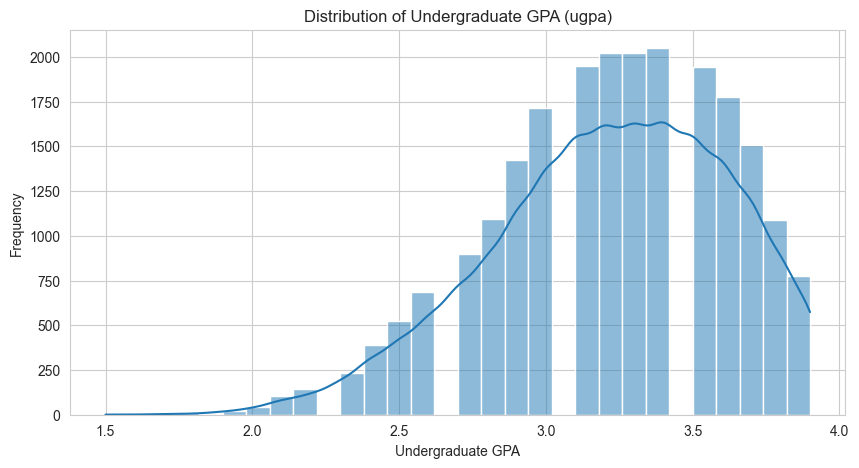

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(data['ugpa'], kde=True, bins=30)
plt.title('Distribution of Undergraduate GPA (ugpa)')
plt.xlabel('Undergraduate GPA')
plt.ylabel('Frequency')
plt.show()

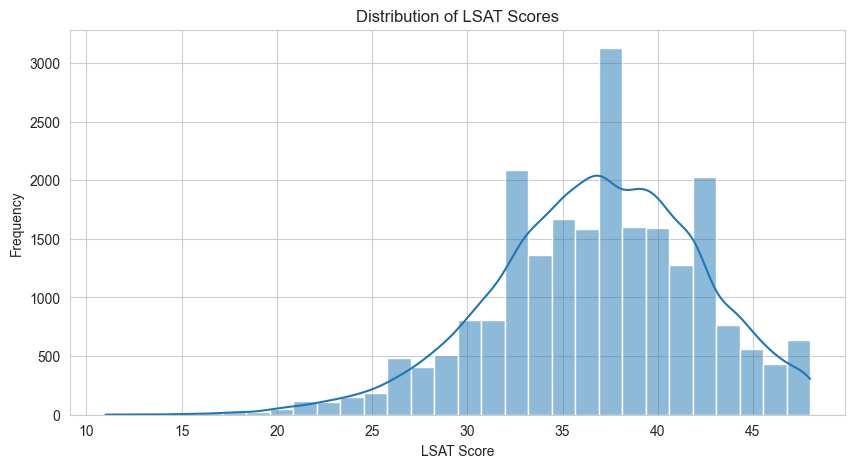

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot(data['lsat'], kde=True, bins=30)
plt.title('Distribution of LSAT Scores')
plt.xlabel('LSAT Score')
plt.ylabel('Frequency')
plt.show()

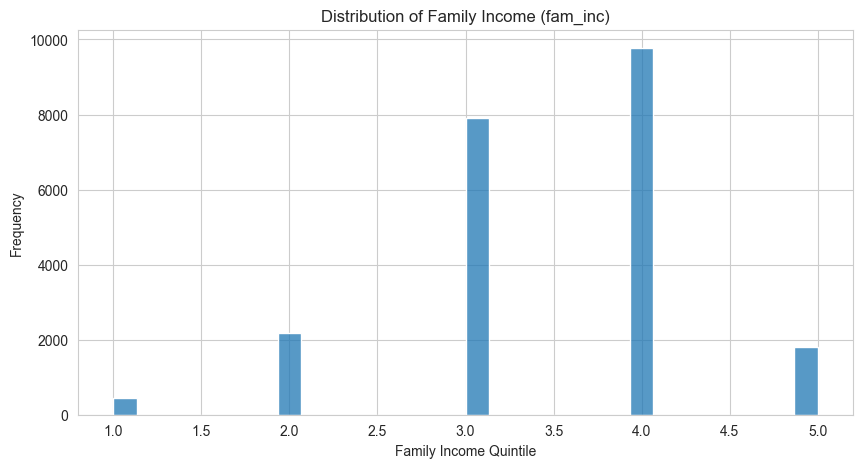

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(data['fam_inc'], kde=False, bins=30)
plt.title('Distribution of Family Income (fam_inc)')
plt.xlabel('Family Income Quintile')
plt.ylabel('Frequency')
plt.show()

First Quintile (1.0): This is the lowest income group and represents the bottom 20% of the population in terms of income.
Second Quintile (2.0): This group is above the lowest 20% but below the median, representing families with income greater than 20% of the population but less than 40%.
Third Quintile (3.0): This is the middle income group, indicating families with income greater than 40% but less than 60% of the population, essentially the middle class.
Fourth Quintile (4.0): This quintile represents families with income greater than 60% but less than 80% of the population, typically upper-middle-class families.
Fifth Quintile (5.0): This is the highest income group, representing the top 20% of the population in terms of income.

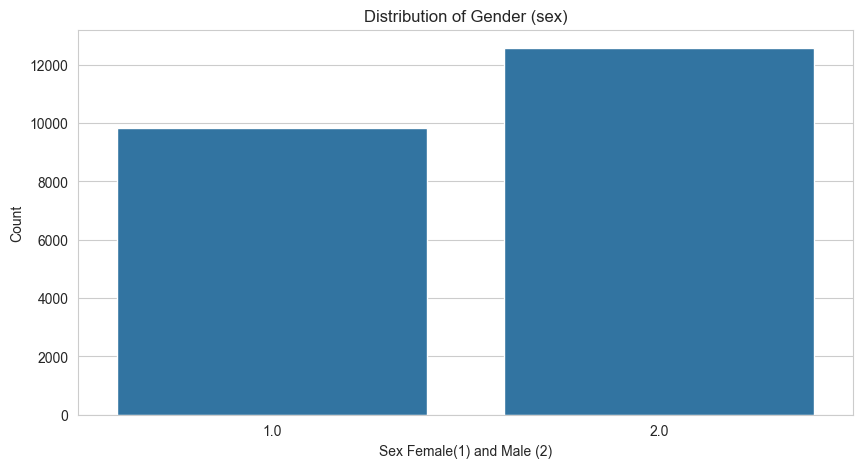

In [16]:
plt.figure(figsize=(10, 5))
sns.countplot(x='sex', data=data)
plt.title('Distribution of Gender (sex)')
plt.xlabel('Sex Female(1) and Male (2)')
plt.ylabel('Count')
plt.show()


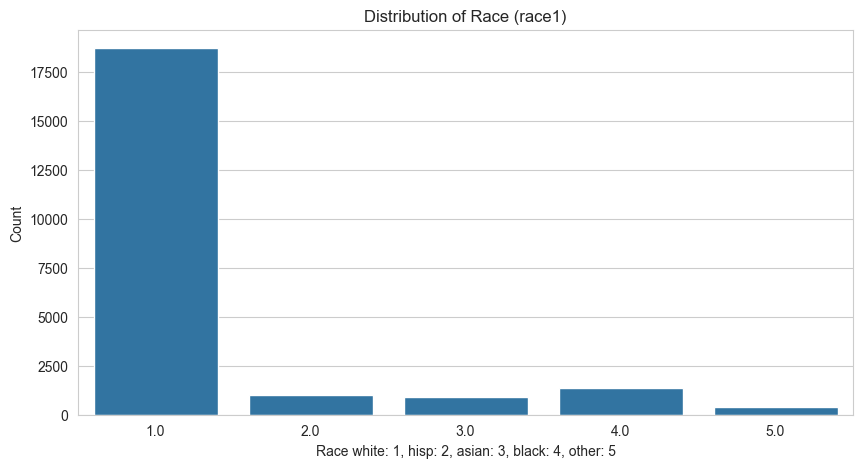

In [17]:
plt.figure(figsize=(10, 5))
sns.countplot(x='race1', data=data)
plt.title('Distribution of Race (race1)')
plt.xlabel('Race white: 1, hisp: 2, asian: 3, black: 4, other: 5')
plt.ylabel('Count')
plt.show()

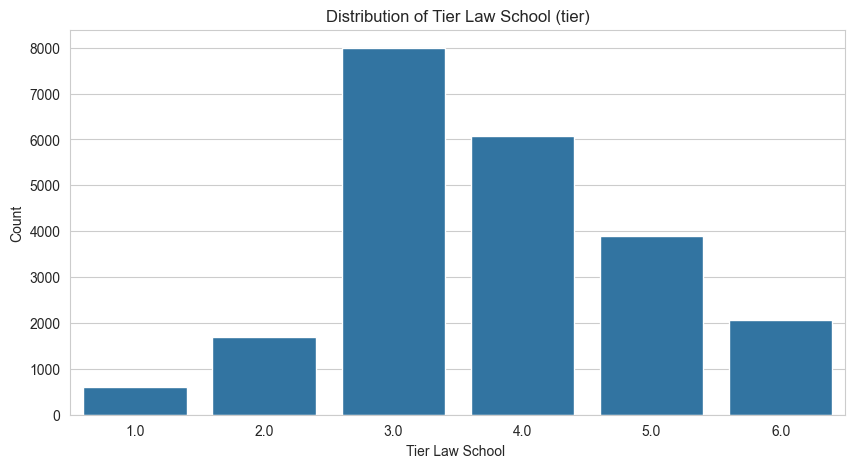

In [18]:
plt.figure(figsize=(10, 5))
sns.countplot(x='tier', data=data)
plt.title('Distribution of Tier Law School (tier)')
plt.xlabel('Tier Law School ')
plt.ylabel('Count')
plt.show()

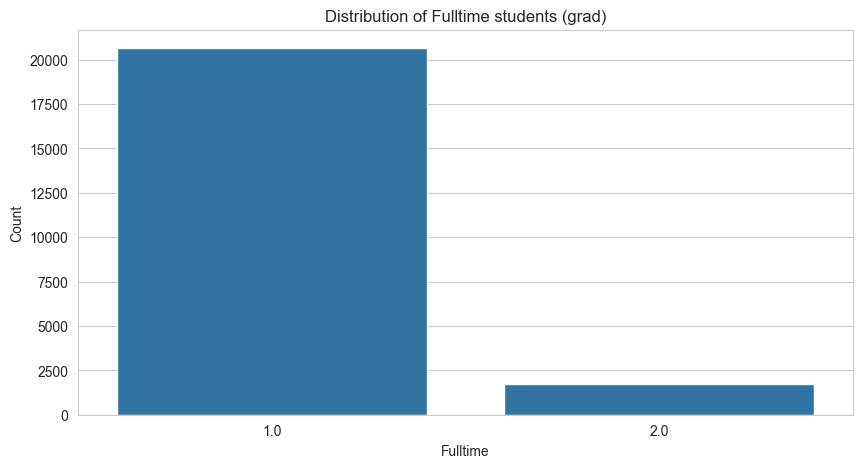

In [19]:
plt.figure(figsize=(10, 5))
sns.countplot(x='fulltime', data=data)
plt.title('Distribution of Fulltime students (grad)')
plt.xlabel('Fulltime')
plt.ylabel('Count')
plt.show()

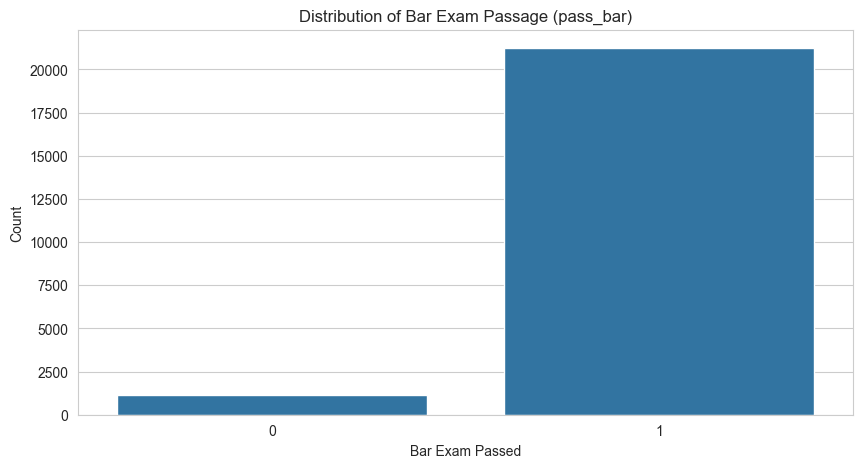

In [20]:
plt.figure(figsize=(10, 5))
sns.countplot(x='pass_bar', data=data)
plt.title('Distribution of Bar Exam Passage (pass_bar)')
plt.xlabel('Bar Exam Passed')
plt.ylabel('Count')
plt.show()

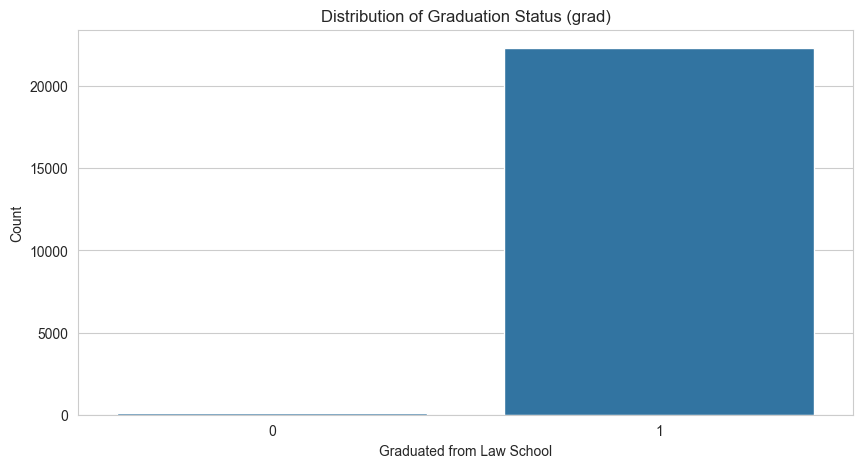

In [21]:
plt.figure(figsize=(10, 5))
sns.countplot(x='grad', data=data)
plt.title('Distribution of Graduation Status (grad)')
plt.xlabel('Graduated from Law School')
plt.ylabel('Count')
plt.show()

Data Exploration Correlations

In [22]:
data.corr()

,pass_bar,ugpa,decile1,decile1b,decile3,lsat,grad,fulltime,fam_inc,tier,race1,sex
pass_bar,1.000000,0.143276,0.233723,0.233882,0.261553,0.238447,0.063399,-0.066872,0.080050,0.099165,-0.188697,0.022349
ugpa,0.143276,1.000000,0.164697,0.172168,0.218472,0.243069,0.042873,-0.114209,0.012421,0.320255,-0.183705,-0.135580
decile1,0.233723,0.164697,1.000000,0.990840,0.862383,0.264824,0.023045,0.015230,0.077659,-0.028360,-0.256727,0.047388
decile1b,0.233882,0.172168,0.990840,1.000000,0.864000,0.275698,NaN,0.015093,0.078645,-0.002545,-0.251372,0.044770
decile3,0.261553,0.218472,0.862383,0.864000,1.000000,0.288307,NaN,0.010081,0.080419,-0.005736,-0.267617,0.009074
lsat,0.238447,0.243069,0.264824,0.275698,0.288307,1.000000,0.042726,-0.104160,0.174569,0.450824,-0.314189,0.077305
grad,0.063399,0.042873,0.023045,NaN,NaN,0.042726,1.000000,-0.020784,-0.000102,0.021701,-0.026693,-0.006123
fulltime,-0.066872,-0.114209,0.015230,0.015093,0.010081,-0.104160,-0.020784,1.000000,-0.072596,-0.033032,-0.014293,-0.006282
fam_inc,0.080050,0.012421,0.077659,0.078645,0.080419,0.174569,-0.000102,-0.072596,1.000000,0.080375,-0.184195,0.043686
tier,0.099165,0.320255,-0.028360,-0.002545,-0.005736,0.450824,0.021701,-0.033032,0.080375,1.000000,0.003123,-0.013946


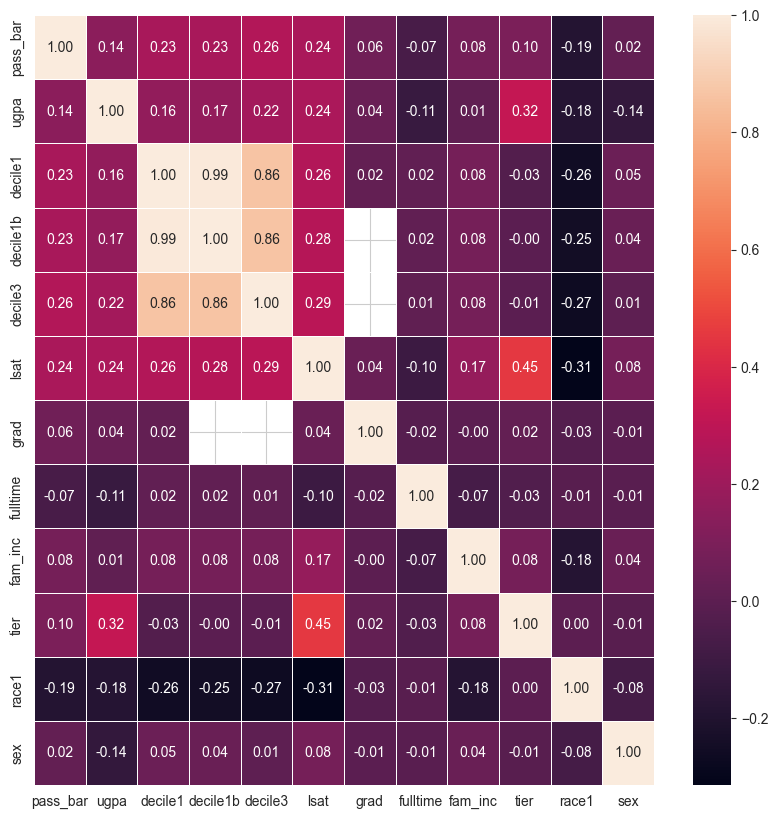

In [23]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.show()

From the provided correlation heatmap, we can make several observations:

Strong Positive Correlations:

decile1, decile1b, and decile3 are very strongly correlated with each other, which suggests they are likely representing similar or related aspects of law school rankings across different times. These variables may be redundant.
lsat also shows a good positive correlation with these decile variables, indicating that LSAT scores are likely higher among students from higher-ranked law schools.
tier has a strong positive correlation with lsat, which might indicate that students with higher LSAT scores tend to go to higher-tier law schools.
Correlation with Outcome Variable (pass_bar):

lsat has a moderate positive correlation with pass_bar, suggesting that higher LSAT scores might be associated with a greater likelihood of passing the bar exam.
ugpa shows a slight positive correlation with pass_bar, indicating that undergraduate GPA may have a lesser but still positive influence on passing the bar.
Negative Correlations:

race1 shows a moderate negative correlation with decile1, decile1b, decile3, and lsat. This could suggest that certain racial groups are less represented in higher-ranked law schools or have lower LSAT scores, which might be an area of concern for diversity and representation.
race1 also has a negative correlation with pass_bar, which might imply that the race encoded with higher numbers (possibly representing minority groups) have a lower rate of passing the bar exam.
Other Observations:

grad does not show strong correlations with other variables, which might indicate that whether or not a student graduates doesn't vary strongly with these measured factors.
fulltime and fam_inc also do not show strong correlations with the outcome variable or other explanatory variables.
sex shows very little to no correlation with other variables, suggesting there might not be a strong gender bias in terms of LSAT scores, law school deciles, or passing the bar exam within this dataset.

Data Exploration - Pass Rate to Gender, Race & Family Income

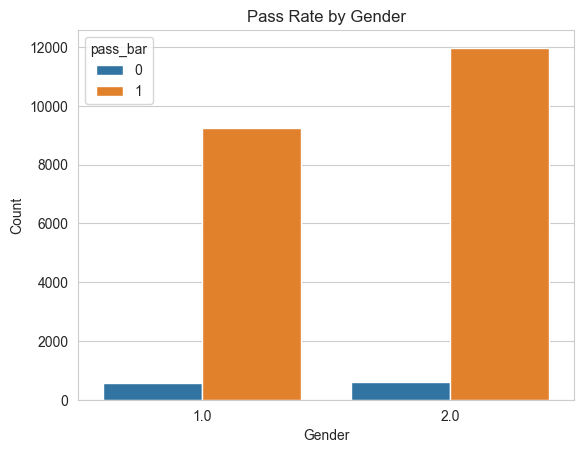

In [24]:

# Visualization of pass rate by gender
sns.countplot(x='sex', hue='pass_bar', data=data)
plt.title('Pass Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

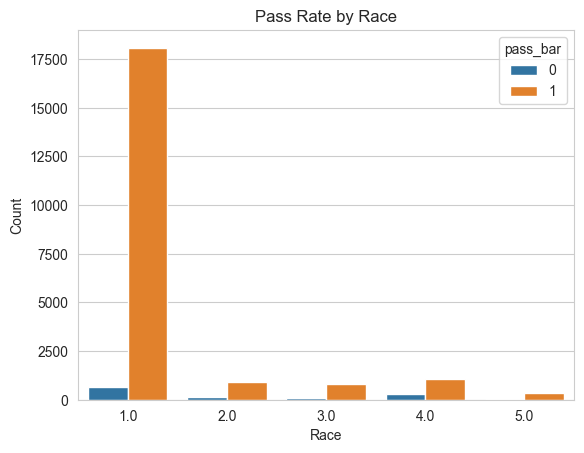

In [25]:

# Visualization of pass rate by race
sns.countplot(x='race1', hue='pass_bar', data=data)
plt.title('Pass Rate by Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

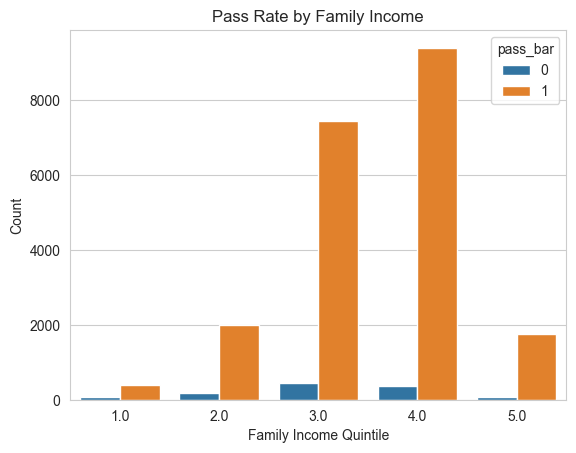

In [26]:
# Visualization of pass rate by family income
sns.countplot(x='fam_inc', hue='pass_bar', data=data)
plt.title('Pass Rate by Family Income')
plt.xlabel('Family Income Quintile')
plt.ylabel('Count')
plt.show()

In [27]:
# Statistical summary of pass rate by gender
gender_pass_rate = data.groupby('sex')['pass_bar'].mean()
print('Gender by pass rate:', gender_pass_rate)

# Statistical summary of pass rate by race
race_pass_rate = data.groupby('race1')['pass_bar'].mean()
print('Race by pass rate: ',race_pass_rate)

# Statistical summary of pass rate by family income
fam_inc_pass_rate = data.groupby('fam_inc')['pass_bar'].mean()
print('Family income by pass rate: ',fam_inc_pass_rate)


Gender by pass rate: sex
1.0    0.942194
2.0    0.952211
Name: pass_bar, dtype: float64
Race by pass rate:  race1
1.0    0.966392
2.0    0.875365
3.0    0.921962
4.0    0.778109
5.0    0.897059
Name: pass_bar, dtype: float64
Family income by pass rate:  fam_inc
1.0    0.861233
2.0    0.912964
3.0    0.943389
4.0    0.961314
5.0    0.962514
Name: pass_bar, dtype: float64


Data Exploration - Graduated from Law School to Gender, Race & Family Income

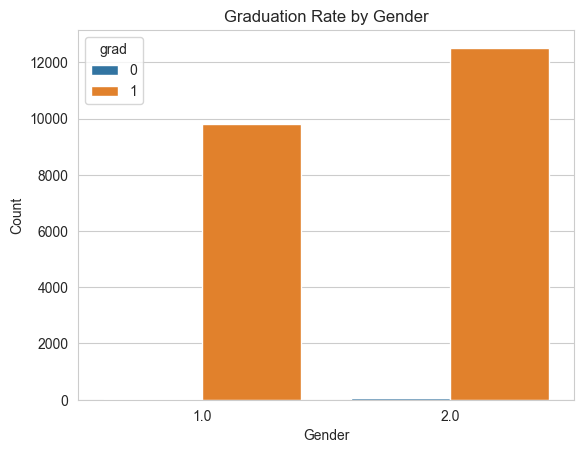

In [28]:
# Visualization of graduation rate by gender
sns.countplot(x='sex', hue='grad', data=data)
plt.title('Graduation Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


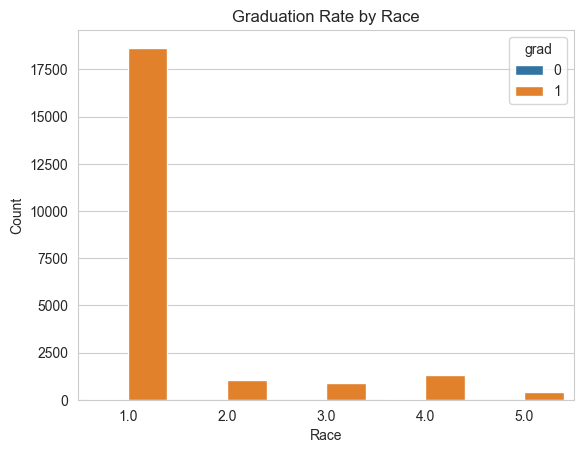

In [29]:
# Visualization of graduation rate by race
sns.countplot(x='race1', hue='grad', data=data)
plt.title('Graduation Rate by Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

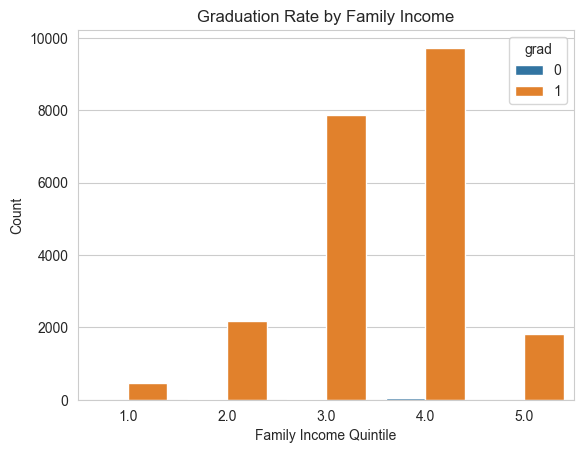

In [30]:
# Visualization of graduation rate by family income
sns.countplot(x='fam_inc', hue='grad', data=data)
plt.title('Graduation Rate by Family Income')
plt.xlabel('Family Income Quintile')
plt.ylabel('Count')
plt.show()


In [31]:
# Statistical summary of graduation rate by gender
gender_grad_rate = data.groupby('sex')['grad'].mean()
print('Gender by grad rate: ', gender_grad_rate)

# Statistical summary of graduation rate by race
race_grad_rate = data.groupby('race1')['grad'].mean()
print('Race by Grad rate: ', race_grad_rate)

# Statistical summary of graduation rate by family income
fam_inc_grad_rate = data.groupby('fam_inc')['grad'].mean()
print('Family income by grad rate: ', fam_inc_grad_rate)

Gender by grad rate:  sex
1.0    0.996336
2.0    0.995547
Name: grad, dtype: float64
Race by Grad rate:  race1
1.0    0.996687
2.0    0.995131
3.0    0.989967
4.0    0.988086
5.0    1.000000
Name: grad, dtype: float64
Family income by grad rate:  fam_inc
1.0    0.993392
2.0    0.996793
3.0    0.995947
4.0    0.995497
5.0    0.996692
Name: grad, dtype: float64


SDG - Synthetic Minority Over-sampling Technique (SMOTE)

SMOTE does not tolerate NaNs so we need to inpute them first!!!

In [32]:
# Cell 4: Define features and target variable
X = data.drop('pass_bar', axis=1) # features
y = data['pass_bar'] # target variable

# Cell 5: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cell 6: Summarize class distribution
print(f"Original dataset shape {Counter(y_train)}")

Original dataset shape Counter({1: 16982, 0: 943})


In [33]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Apply the imputer to our data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert the imputed arrays back to DataFrames
X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Cell 5: Summarize class distribution after imputation
print(f"Training dataset shape after imputation {X_train.shape}")


Training dataset shape after imputation (17925, 11)


In [34]:


# Cell 7: Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Cell 8: Summarize the new class distribution
print(f"Resampled dataset shape {Counter(y_res)}")

# Cell 9: Create a DataFrame of the synthetic dataset
synthetic_data_smote = pd.DataFrame(X_res, columns=X_train.columns)
synthetic_data_smote['pass_bar'] = y_res

# Save the synthetic dataset to a new CSV file
synthetic_data_smote.to_csv('synthetic_data_smote.csv', index=False)

# Cell 10: Display the first few rows of the synthetic dataset
print(synthetic_data_smote.head())

Resampled dataset shape Counter({1: 16982, 0: 16982})
   ugpa  decile1  decile1b  decile3  lsat  grad  fulltime  fam_inc  tier  \
0   3.3      3.0       3.0      5.0  38.0   1.0       2.0      1.0   4.0   
1   3.8     10.0      10.0     10.0  42.0   1.0       1.0      5.0   4.0   
2   3.4      2.0       2.0      2.0  40.0   1.0       1.0      4.0   3.0   
3   3.8      6.0       6.0      6.0  44.0   1.0       1.0      4.0   6.0   
4   3.0      7.0       6.0      8.0  26.5   1.0       1.0      4.0   3.0   

   race1  sex  pass_bar  
0    1.0  1.0         1  
1    1.0  1.0         1  
2    1.0  1.0         1  
3    1.0  1.0         1  
4    5.0  1.0         1  


SMOTE SDG Data Expolration

In [35]:
# Summary statistics for the original dataset
original_summary = data.describe()

# Summary statistics for the synthetic dataset
synthetic_summary = synthetic_data_smote.describe()

# Print summary statistics side by side
print("Original Dataset Summary")
print(original_summary)
print("\nSynthetic Dataset Summary")
print(synthetic_summary)

Original Dataset Summary
           pass_bar          ugpa       decile1      decile1b       decile3  \
count  22407.000000  22407.000000  21315.000000  20803.000000  20803.000000   
mean       0.947829      3.215451      5.708234      5.528481      5.525934   
std        0.222377      0.404073      2.783098      2.854800      2.851286   
min        0.000000      1.500000      1.000000      1.000000      1.000000   
25%        1.000000      3.000000      3.000000      3.000000      3.000000   
50%        1.000000      3.200000      6.000000      6.000000      6.000000   
75%        1.000000      3.500000      8.000000      8.000000      8.000000   
max        1.000000      3.900000     10.000000     10.000000     10.000000   

               lsat          grad      fulltime       fam_inc          tier  \
count  22407.000000  22407.000000  22373.000000  22118.000000  22311.000000   
mean      36.767907      0.995894      1.076878      3.466046      3.768814   
std        5.463248      0

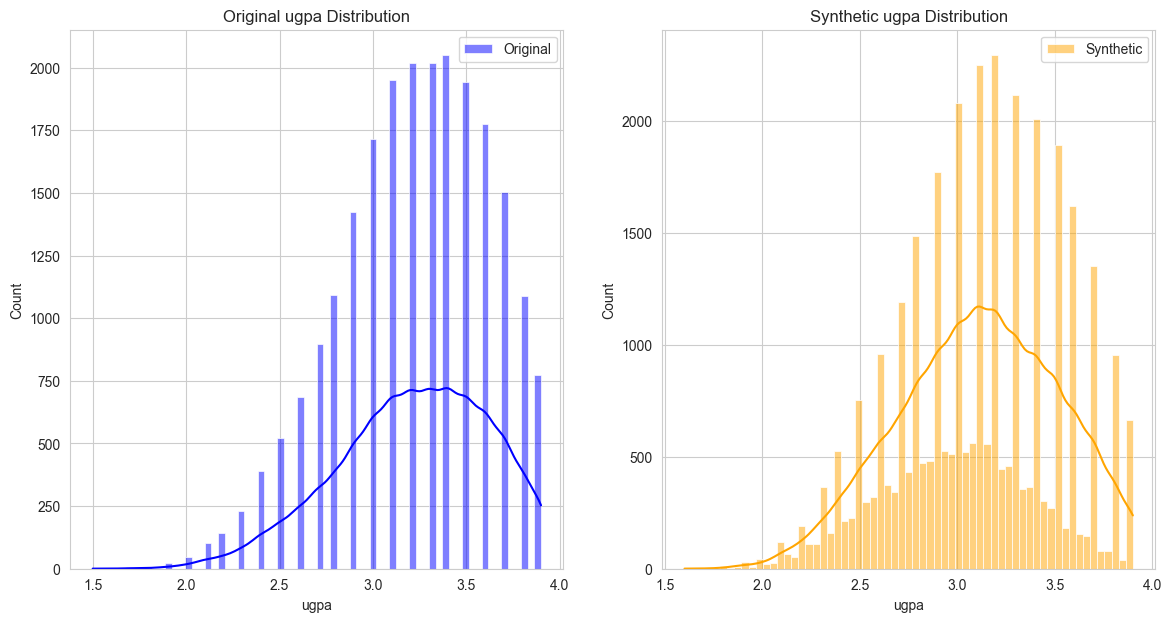

In [36]:

# Compare distributions for a particular feature, e.g., 'ugpa'
plt.figure(figsize=(14, 7))

# Histogram for the original dataset
plt.subplot(1, 2, 1)
sns.histplot(data['ugpa'], kde=True, color='blue', label='Original')
plt.title('Original ugpa Distribution')
plt.legend()

# Histogram for the synthetic dataset
plt.subplot(1, 2, 2)
sns.histplot(synthetic_data_smote['ugpa'], kde=True, color='orange', label='Synthetic')
plt.title('Synthetic ugpa Distribution')
plt.legend()

plt.show()

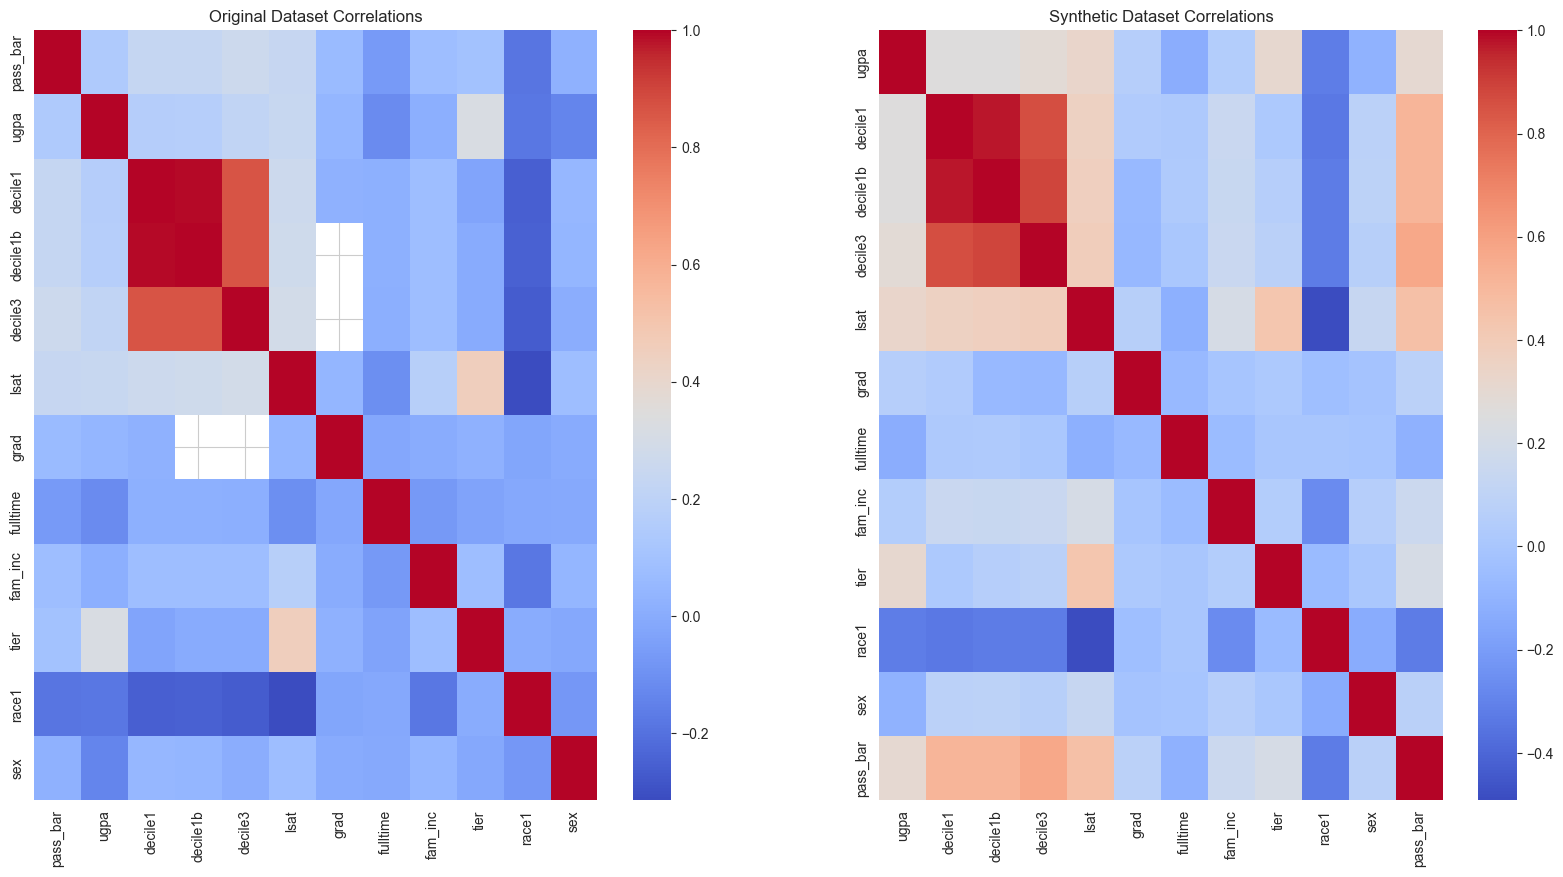

In [37]:
# Correlation matrix for the original dataset
original_corr = data.corr()

# Correlation matrix for the synthetic dataset
synthetic_corr = synthetic_data_smote.corr()

# Plot both correlation matrices side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Original
sns.heatmap(original_corr, ax=ax[0], cmap='coolwarm')
ax[0].set_title('Original Dataset Correlations')

# Synthetic
sns.heatmap(synthetic_corr, ax=ax[1], cmap='coolwarm')
ax[1].set_title('Synthetic Dataset Correlations')

plt.show()


Evaluating the Quality of SMOTE SDG method

Evaluating Uniqueness

In [39]:
# Uniqueness column by column

# Function to calculate the uniqueness score
def calculate_uniqueness(dataframe, column):
    unique_count = len(dataframe[column].drop_duplicates())
    total_count = len(dataframe)
    uniqueness_score = unique_count / total_count
    return uniqueness_score

# Assuming `data` is your original DataFrame and `synthetic_data_smote` is your synthetic DataFrame
uniqueness_results = {
    'Column': [],
    'Original Uniqueness': [],
    'Synthetic Uniqueness': []
}

for column in data.columns:
    original_uniqueness = calculate_uniqueness(data, column)
    synthetic_uniqueness = calculate_uniqueness(synthetic_data_smote, column)
    uniqueness_results['Column'].append(column)
    uniqueness_results['Original Uniqueness'].append(original_uniqueness)
    uniqueness_results['Synthetic Uniqueness'].append(synthetic_uniqueness)

# Convert the results to a DataFrame for easier viewing
uniqueness_df = pd.DataFrame(uniqueness_results)

# Display the results
print(uniqueness_df)



      Column  Original Uniqueness  Synthetic Uniqueness
0   pass_bar             0.000089              0.000059
1       ugpa             0.001116              0.431457
2    decile1             0.000491              0.186550
3   decile1b             0.000491              0.153339
4    decile3             0.000491              0.182752
5       lsat             0.005177              0.316453
6       grad             0.000089              0.009834
7   fulltime             0.000134              0.087210
8    fam_inc             0.000268              0.229832
9       tier             0.000312              0.222147
10     race1             0.000268              0.115240
11       sex             0.000134              0.157461


Interpretation of uniqueness results:

The Original Uniqueness scores are very low, indicating that each column in the original dataset has a high degree of duplication, which is expected for categorical variables or those with limited ranges like pass_bar, fulltime, or sex. In contrast, the Synthetic Uniqueness scores are substantially higher for nearly all columns, especially ugpa and lsat, suggesting that the synthetic data has a wider variety of unique values, possibly too wide compared to the original. This discrepancy indicates that the synthetic data may overrepresent diversity, failing to accurately capture the distribution characteristics of the original dataset, which may affect its utility for certain applications.

Statistical Distribution Tests

Null hypothesis: the original and synthetic samples are drawn from the same distribution.

In [40]:
from scipy.stats import ks_2samp

# Ensure only columns present in both DataFrames are compared
common_columns = set(data.columns).intersection(synthetic_data_smote.columns)

ks_test_results = {}
for column in common_columns:
    statistic, p_value = ks_2samp(data[column].values, synthetic_data_smote[column].values)
    ks_test_results[column] = {'statistic': statistic, 'p_value': p_value}

ks_test_df = pd.DataFrame(ks_test_results).T
print(ks_test_df)


          statistic        p_value
sex        0.114768  2.313005e-155
decile3    0.244422   0.000000e+00
lsat       0.181655   0.000000e+00
decile1    0.212880   0.000000e+00
fam_inc    0.113954  3.638354e-153
ugpa       0.136699  1.690986e-220
tier       0.098761  4.488320e-115
pass_bar   0.447829   0.000000e+00
decile1b   0.225558   0.000000e+00
fulltime   0.068376   2.527303e-55
grad       0.011087   7.186057e-02
race1      0.163858  3.293736e-317


In [41]:
from scipy.stats import chi2_contingency
import pandas as pd

# Function to perform the Chi-Squared Test on a categorical column
def chi_squared_test(original, synthetic, column):
    contingency_table = pd.crosstab(original[column], synthetic[column])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    return chi2, p_value

# Assuming `original_data` is your original DataFrame and `synthetic_data_smote` is your synthetic DataFrame
categorical_columns = ['pass_bar', 'fulltime', 'tier', 'race1', 'sex']  # List of categorical columns
chi_squared_results = {}

for column in categorical_columns:
    chi2, p_value = chi_squared_test(data, synthetic_data_smote, column)
    chi_squared_results[column] = {'chi2': chi2, 'p_value': p_value}

# Convert the results to a DataFrame for easier viewing
chi_squared_df = pd.DataFrame(chi_squared_results).T

# Display the results
print(chi_squared_df)


                  chi2       p_value
pass_bar     38.498061  5.480812e-10
fulltime   1023.819806  8.372783e-06
tier      12278.312098  6.863542e-27
race1      5398.824959  2.384734e-22
sex        1419.388267  6.796944e-01


Now with applied Bonferroni criterion to control the false discovery rate in multiple hypothesis testing

In [42]:
from scipy.stats import ks_2samp, anderson_ksamp
from statsmodels.stats.multitest import multipletests

# Assuming you have the following columns defined
continuous_columns = ['ugpa', 'lsat', 'fam_inc', 'decile1', 'decile1b', 'decile3']
categorical_columns = ['fulltime', 'tier', 'race1', 'sex'] # Add your actual categorical columns here

# KS Test with Bonferroni correction
ks_test_p_values = []
for column in continuous_columns:
    statistic, p_value = ks_2samp(data[column].values, synthetic_data_smote[column].values)
    ks_test_p_values.append(p_value)

# Apply Bonferroni Correction
reject, pvals_corrected, _, _ = multipletests(ks_test_p_values, alpha=0.05, method='bonferroni')

# Print the results
print("KS Test Results with Bonferroni Correction:")
for i, column in enumerate(continuous_columns):
    print(f"{column}: p-value={pvals_corrected[i]:} - {'Reject' if reject[i] else 'Fail to reject'} the null hypothesis")

# Chi-Squared Test with Bonferroni correction
chi_squared_p_values = []
for column in categorical_columns:
    chi2, p_value = chi_squared_test(data, synthetic_data_smote, column)
    chi_squared_p_values.append(p_value)

# Apply Bonferroni Correction
reject, pvals_corrected, _, _ = multipletests(chi_squared_p_values, alpha=0.05, method='bonferroni')

# Print the results
print("\nChi-Squared Test Results with Bonferroni Correction:")
for i, column in enumerate(categorical_columns):
    print(f"{column}: p-value={pvals_corrected[i]:} - {'Reject' if reject[i] else 'Fail to reject'} the null hypothesis")

# Anderson-Darling Test without correction (to be corrected below)
ad_test_results = []
for column in continuous_columns:
    statistic, critical_values, significance_level = anderson_ksamp([data[column].values, synthetic_data_smote[column].values])
    ad_test_results.append((column, statistic, significance_level))

# Apply Bonferroni Correction for Anderson-Darling Test
reject_ad, pvals_corrected_ad, _, _ = multipletests([result[2] for result in ad_test_results], alpha=0.05, method='bonferroni')

# Print the Anderson-Darling test results
print("\nAnderson-Darling Test Results with Bonferroni Correction:")
for i, result in enumerate(ad_test_results):
    print(f"{result[0]}: statistic={result[1]:.4f}, p-value={pvals_corrected_ad[i]:.4f} - {'Reject' if reject_ad[i] else 'Fail to reject'} the null hypothesis")



KS Test Results with Bonferroni Correction:
ugpa: p-value=1.014591528664202e-219 - Reject the null hypothesis
lsat: p-value=0.0 - Reject the null hypothesis
fam_inc: p-value=2.1830122100334274e-152 - Reject the null hypothesis
decile1: p-value=0.0 - Reject the null hypothesis
decile1b: p-value=0.0 - Reject the null hypothesis
decile3: p-value=0.0 - Reject the null hypothesis

Chi-Squared Test Results with Bonferroni Correction:
fulltime: p-value=3.3491130092185615e-05 - Reject the null hypothesis
tier: p-value=2.745416740934898e-26 - Reject the null hypothesis
race1: p-value=9.538936591579645e-22 - Reject the null hypothesis
sex: p-value=1.0 - Fail to reject the null hypothesis

Anderson-Darling Test Results with Bonferroni Correction:
ugpa: statistic=698.0967, p-value=0.0060 - Reject the null hypothesis
lsat: statistic=1644.0826, p-value=0.0060 - Reject the null hypothesis
fam_inc: statistic=400.4722, p-value=0.0060 - Reject the null hypothesis
decile1: statistic=2723.6187, p-value=0.

C:\Users\20181588\AppData\Local\Temp\ipykernel_28748\3945237861.py:39: UserWarning: p-value floored: true value smaller than 0.001
  statistic, critical_values, significance_level = anderson_ksamp([data[column].values, synthetic_data_smote[column].values])


Interpreting evaluation results:

KS Test Results:
The KS test results show p-values of 0.0000 for the continuous variables (ugpa, lsat, fam_inc, decile1, decile1b, decile3), even after applying the Bonferroni correction. This strongly suggests that for each of these variables, the synthetic data distribution significantly differs from the original data distribution. Because the Bonferroni correction is a conservative approach to control the family-wise error rate, the fact that you still reject the null hypothesis indicates that the differences between the distributions of the original and synthetic data are very pronounced.

Chi-Squared Test Results:
For the categorical variables, the p-values show that for fulltime, tier, and race1, the synthetic data significantly differs from the original data, similar to the KS test results. Since we reject the null hypothesis, it means that the categories' distributions in the synthetic data do not match those in the original data.

However, for sex, the p-value is 1.0000, which is the maximum value a p-value can have, indicating that there is no evidence to suggest a difference in distribution between the original and synthetic data for this variable. This means that the sex variable in the synthetic data does a good job of replicating the distribution of the sex variable in the original data.

Anderson-Darling Test Results:
The Anderson-Darling test results, even after Bonferroni correction, show that we reject the null hypothesis for all tested continuous variables (ugpa, lsat, fam_inc, decile1, decile1b, decile3). This implies that the synthetic data does not follow the same distribution as the original data, particularly at the tails of the distributions. Since the Anderson-Darling test is more sensitive to the tails than the KS test, the significant results here emphasize that there may be notable differences in the extremes of the data distributions. This could be critical if the extremities hold particular importance in the context of your analysis or use case.

Given that the test is sensitive to the tails where extreme values lie, this might suggest that the synthetic data generation process does not capture extreme behaviors or outliers as effectively as the central tendencies. This aspect is particularly important in fields where extreme values can have disproportionate impacts, such as finance or risk assessment.

Overall Interpretation:
The comprehensive rejection of the null hypothesis across the KS test, Chi-Squared test, and the Anderson-Darling test indicates that the synthetic dataset has significant distributional discrepancies from the original data across the board. This includes both the general distribution as assessed by the KS test and the distribution tails as assessed by the Anderson-Darling test. The only exception appears to be the distribution of the sex variable, which the synthetic data replicates well according to the Chi-Squared test.

These results point to a need to review and potentially refine the synthetic data generation process. It may be necessary to explore alternative methods or adjust the existing ones to better capture the underlying distributions, especially for the continuous variables and the extremities of the data. The current synthetic data might still be useful for certain types of analyses that are less sensitive to distributional accuracy or for scenarios where maintaining privacy is more critical than preserving exact statistical properties. However, for tasks that require high fidelity to the original data's distribution, further work is needed to improve the synthetic dataset's quality.

Total variation complement - The Total variation distance measures how far two probability distributions are

Description: The Total Variation (TV) distance is a measure of the difference between two probability distributions. For discrete distributions, it's defined as half the sum of the absolute differences between the probabilities that the two distributions assign to each outcome. It essentially captures the maximum difference in probabilities assigned to any event by the two distributions.

Total Variation distance is particularly useful in the context of Synthetic Data Generation (SDG) because:

Measuring Fidelity: It helps in quantifying how well the synthetic data represents the real data in terms of distribution. A small TV distance would indicate that the synthetic data closely matches the real data.

Applicability to Categorical Data: It's suitable for discrete or categorical data, which is common in many real-world datasets.

Interpretability: The complement of the TV distance (1 - TV distance) provides an intuitive measure of similarity between two distributions, with values closer to 1 indicating more similarity.

In [43]:
def total_variation_distance_and_complement(distribution1, distribution2):
    tv_distance = 0.5 * np.sum(np.abs(distribution1 - distribution2))
    tv_complement = 1 - tv_distance
    return tv_distance, tv_complement

# List of categorical columns to test
categorical_columns = ['fulltime', 'tier', 'race1', 'sex']

# Results dictionary to store the Total Variation distance and complement for each column
tv_results = {
    'Column': [],
    'Total Variation Distance': [],
    'Total Variation Complement': []
}

for column in categorical_columns:
    # Get the normalized value counts (probabilities) for each category in the column
    original_probs = original_data[column].value_counts(normalize=True).sort_index()
    synthetic_probs = synthetic_data_smote[column].value_counts(normalize=True).sort_index()
    
    # Ensure both distributions cover the same set of categories
    combined_categories = original_probs.index.union(synthetic_probs.index)
    original_probs = original_probs.reindex(combined_categories, fill_value=0)
    synthetic_probs = synthetic_probs.reindex(combined_categories, fill_value=0)
    
    # Calculate TV distance and its complement
    tv_distance, tv_complement = total_variation_distance_and_complement(original_probs.values, synthetic_probs.values)
    
    # Store the results
    tv_results['Column'].append(column)
    tv_results['Total Variation Distance'].append(tv_distance)
    tv_results['Total Variation Complement'].append(tv_complement)

# Convert the results to a DataFrame for easier viewing
tv_df = pd.DataFrame(tv_results)

# Display the results
print(tv_df)


     Column  Total Variation Distance  Total Variation Complement
0  fulltime                  0.087151                9.128489e-01
1      tier                  0.239187                7.608128e-01
2     race1                  1.000000                2.220446e-16
3       sex                  0.157402                8.425980e-01


Conditional or multivariate variants of tests 

Gaussian Mixture Model

In [44]:
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the entire dataset (excluding the target variable 'pass_bar')
imputer.fit(data.drop('pass_bar', axis=1))

# Apply the imputer to the entire dataset
data_imputed = imputer.transform(data.drop('pass_bar', axis=1))
synthetic_data_imputed = imputer.transform(synthetic_data_smote.drop('pass_bar', axis=1))

# It's often a good idea to scale the data when using GMM because it assumes that the data is centered
scaler = StandardScaler()
data_imputed_scaled = scaler.fit_transform(data_imputed)
synthetic_data_imputed_scaled = scaler.transform(synthetic_data_imputed)

# Fit a Gaussian Mixture Model to the imputed and scaled real data
n_components = 3  # Example value, adjust as necessary
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(data_imputed_scaled)

# Assess the likelihood of the synthetic data under the fitted GMM
synthetic_scores = gmm.score_samples(synthetic_data_imputed_scaled)

# The overall log likelihood (mean log likelihood) of the synthetic data
mean_log_likelihood = np.mean(synthetic_scores)

# Print the results
print(f"The mean log likelihood of the synthetic data under the GMM: {mean_log_likelihood}")



The mean log likelihood of the synthetic data under the GMM: -51212.34359094306


GMM test interpretation:

The mean log likelihood value of the synthetic data under the Gaussian Mixture Model (GMM) is approximately -51212.34, which is a measure of how well the synthetic data fits the probability distribution as modeled by the GMM. A higher (less negative) log likelihood indicates a better fit to the model, so this highly negative value suggests that the synthetic data may not closely match the distribution of the real data. This could mean that the synthetic data generation process needs to be adjusted to better capture the underlying patterns and distributions of the original dataset.




Privacy - to be continued

ML Efficacy - to be continued

SDG - Resampling-based Methods - Undersampling

SDG - Resampling-based Methods - Oversampling

SDG - Modification of Resampled Samples - Interpolation

SDG - Modification of Resampled Samples - Adding small prtyrbations